In [7]:
### Upload the file containing the spin configurations: ###
### (Press "Choose Files" and navigate to where you have stored the file 'gaugeTheoryConfigs.txt')
#from google.colab import files
#files.upload()

In [238]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from statistics import mean
from itertools import groupby


#fileName  = 'x_L30.txt'          # The file where the configurations are stored
#configs   = np.loadtxt(fileName,dtype='int8') # Read the data from file

In [239]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #To use GPUs in PyTorch

### Data parameters: ###
L           = 30    # lattice length L
num_output  = 2     # Number of labels (T=0 and T=infinity here)
#num_sublattices = 2 # Number of sublattices for the gauge theory lattice

### Hyperparameters: ###
frac_train     = 0.7    # Fraction of data used for training
frac_validation     = 0.2
frac_test      = 0.1
#patch_size     = 2      # Size of the filters
#num_filters    = 3#64     # Number of output channels in the convolutional layer
#stride_xy      = 1    # The size of the jumps to take as one slides the filters across the image (the lattice length L should be divisible by stride_xy)
num_hidden      = 100     # Number of hidden neurons in the fully-connected layer
#p_dropout      = 0.5    # Probability of zeroing neurons in the dropout layer
learning_rate  = 1 #0.0001 # Learning rate for training algorithm
minibatch_size = 700   # Mini-batch size (N_train needs to be divisible by minibatch_size)

### Other parameters: ###
N_epochs = 1000          # Number of times to iterate through all of the data

seed=1
np.random.seed(seed)
torch.manual_seed(seed)

### Plotting parameters: ###
#Specify font sizes for plots:
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

In [240]:
### Read in the data: ###
x_all     = np.loadtxt( 'x_L%d.txt' %L, dtype='int16' )
y_all     = np.loadtxt( 'y_L%d.txt' %L, dtype='int16' )
T_all     = np.loadtxt( 'T_L%d.txt' %L, dtype='float32' )
N_configs = x_all.shape[0]
N_spins   = x_all.shape[1]
L         = int( np.sqrt(N_spins) ) #should be the same as the L variable above

### Shuffle the data and then divide into training and validation sets: ###
indices_shuffled = np.random.permutation(N_configs)
x_all = x_all[indices_shuffled,:]
y_all = y_all[indices_shuffled]
T_all = T_all[indices_shuffled]

N_train = int(frac_train*N_configs)
x_train = x_all[0:N_train,:]
y_train = y_all[0:N_train]

N_validation = int(frac_validation*N_configs)
x_validation = x_all[N_train:N_train+N_validation,:]
y_validation = y_all[N_train:N_train+N_validation]

N_test = int(frac_test*N_configs)
x_test = x_all[N_train+N_validation:,:]
y_test = y_all[N_train+N_validation:]
T_test = T_all[N_train+N_validation:]

print("N_train      = %d\nN_validation = %d\nN_test       = %d\n" %(N_train,N_validation,N_test))

N_train      = 7000
N_validation = 2000
N_test       = 1000



In [241]:
class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, self.output_size)
        self.relu    = torch.nn.ReLU() 
        self.elu    = torch.nn.ELU()
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()      
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        a1 = self.sigmoid(linear1_out)
        #Hidden1:
        linear2_out = self.linear2(a1)
        a2 = self.softmax(linear2_out)
        #Network output:
        aL = a2

        return aL

input_size = 900
hidden_size = num_hidden
output_size = num_output
model = FeedforwardNN(input_size, output_size, hidden_size).to(device)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float).to(device) 
x_validation = torch.tensor(x_validation, dtype = torch.float).to(device)
x_test = torch.tensor(x_test, dtype = torch.float).to(device) 

### One hot encoding ###
y_onehot = np.zeros((y_train.size, num_output))
y_onehot[np.arange(y_train.size),y_train] = 1
y_onehot = torch.tensor(y_onehot, dtype = torch.float).to(device)
### One hot encoding valid ###
y_onehot2 = np.zeros((y_validation.size, num_output))
y_onehot2[np.arange(y_validation.size),y_validation] = 1
y_onehot2 = torch.tensor(y_onehot2, dtype = torch.float).to(device)
### One hot encoding test# ##
y_onehot3 = np.zeros((y_test.size, num_output))
y_onehot3[np.arange(y_test.size),y_test] = 1
y_onehot3 = torch.tensor(y_onehot3, dtype = torch.float).to(device)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate ,weight_decay =1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay =1e-5)

### Cost function: ###

#cost_func = torch.nn.MSELoss().to(device) 
cost_func = torch.nn.CrossEntropyLoss().to(device)  

Final Training cost 0.315184
Final Training accuracy 0.998571
Final Validation cost 0.326086
Final Validation accuracy 0.988000


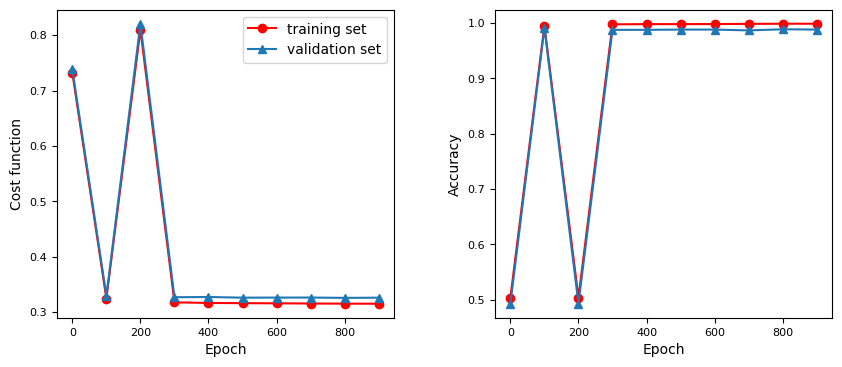

In [242]:
#from re import X
%matplotlib inline
from IPython import display

epoch_list     = []
cost_training  = []
cost_validation  = []
acc_training = []
acc_validation = []

### Train using mini-batches for several epochs: ###
permut = np.arange(N_train)
num_iterations = 0
for epoch in range(N_epochs):
    np.random.shuffle(permut) # Randomly shuffle the indices
    x_shuffled = x_train[permut,:]
    y_shuffled = y_onehot[permut]

    #Loop over all the mini-batches:
    for b in range(0, N_train, minibatch_size):
        x_batch = x_shuffled[b:b+minibatch_size,:]
        y_batch = y_shuffled[b:b+minibatch_size]
        
        optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
       
        NN_output = model(x_batch) # Neural network output
        cost = cost_func(NN_output, y_batch)

        cost.backward()  #computes the gradients
        optimizer.step() #updating the parameters
        
        num_iterations = num_iterations + 1

    #Print results every epoch of the training algorithm:
    if epoch % 100 == 0:
      NN_output_train = model(x_train) # Neural network output
      cost_train = cost_func(NN_output_train, y_onehot).cpu().detach().numpy()
      predicted_class = np.argmax(NN_output_train.cpu().detach().numpy(), axis=1)
      accuracy_training = np.mean(predicted_class == y_train)

      NN_output_validation = model(x_validation) # Neural network output
      cost_valid = cost_func(NN_output_validation, y_onehot2).cpu().detach().numpy()
      predicted_class = np.argmax(NN_output_validation.cpu().detach().numpy(), axis=1)
      accuracy_validation = np.mean(predicted_class == y_validation)

      epoch_list.append(epoch)
      cost_training.append(cost_train)
      cost_validation.append(cost_valid)
      acc_training.append(accuracy_training)
      acc_validation.append(accuracy_validation)
      
      fig = plt.figure(1,figsize=(10,4))
      fig.subplots_adjust(hspace=.3,wspace=.3)
      plt.clf()
      
      ### Plot the cost function: ###
      plt.subplot(121)
      plt.plot(epoch_list,cost_training,'o-r', label = "training set")
      plt.plot(epoch_list,cost_validation, '^-', label = "validation set")
      plt.xlabel('Epoch')
      plt.ylabel('Cost function')
      #plt.ylim(0,1)
      plt.legend()
      
      ### Plot the accuracy: ###
      plt.subplot(122)
      plt.plot(epoch_list,acc_training,'o-r')
      plt.plot(epoch_list,acc_validation, '^-')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      #plt.ylim(0,1)
      #plt.pause(0.1)
      display.display(plt.gcf())
      #print( "Epoch %d:\n  Training cost %f\n  Validation accuracy %f\n" % (epoch, cost_train, accuracy_validation) )
      display.clear_output(wait=True)

#plt.savefig('c) result-10neurons.pdf', bbox_inches="tight")
print("Final Training cost %f\nFinal Training accuracy %f\nFinal Validation cost %f\nFinal Validation accuracy %f" % (cost_train, accuracy_training,cost_valid, accuracy_validation) )

In [123]:
#files.download('c) result-10neurons.pdf') 

In [243]:
NN_output_test = model(x_test)
predicted_class = np.argmax(NN_output_test.cpu().detach().numpy(), axis=1)
accuracy_test = np.mean(predicted_class == y_test)

/tmp/ipykernel_20058/3621773701.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a2 = self.softmax(linear2_out)


In [245]:
(accuracy_test,accuracy_validation)

(0.981, 0.988)

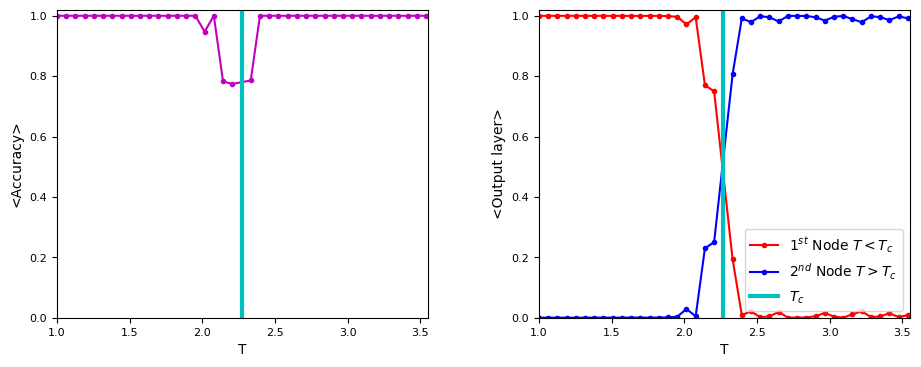

In [296]:
predicted = np.argmax(NN_output_test.cpu().detach().numpy(),axis =1)
accuracy = predicted_class == y_test

data = np.stack((T_test,accuracy),axis = 1)
data = data[data[:,0].argsort()]
grouper = groupby(data, key=lambda x: x[0])
sorted_data = np.array([[x, mean(yi[1] for yi in y)] for x,y in grouper])
#sorted_data = sorted_data[sorted_data[:, 0].argsort()]


data2 = np.stack((T_test, NN_output_test.cpu().detach().numpy()[:,0],NN_output_test.cpu().detach().numpy()[:,1]),axis = 1)
data2 = data2[data2[:,0].argsort()]
grouper = groupby(data2, key=lambda x: x[0])
sorted_data1  = np.array([[x, mean(yi[1] for yi in y)] for x,y in grouper])
#sorted_data1 = sorted_data1[sorted_data1[:, 0].argsort()]

grouper = groupby(data2, key=lambda x: x[0])
sorted_data2  = np.array([[x, mean(yi[2] for yi in y)] for x,y in grouper])
#sorted_data2 = sorted_data2[sorted_data2[:, 0].argsort()]

fig = plt.figure(1,figsize=(11,4))
fig.subplots_adjust(hspace=.3,wspace=.3)
plt.subplot(121)
plt.plot(sorted_data[:,0],sorted_data[:,1],'.m-', label = "training set")
plt.plot(np.zeros(120)+2/(np.log(1+np.sqrt(2))),np.linspace(0,1.1,120),'c-', label = "$T_c$", linewidth="3")
plt.xlabel('T')
plt.ylabel('<Accuracy>')
plt.xlim(1,3.55)
plt.ylim(0,1.02)
#plt.legend()

## Plot the accuracy: ###
plt.subplot(122)
plt.plot(sorted_data1[:,0],sorted_data1[:,1],'.r-', label = "$1^{st}$ Node $T<T_c$")
plt.plot(sorted_data2[:,0],sorted_data2[:,1],'.b-', label = "$2^{nd}$ Node $T>T_c$")
plt.plot(np.zeros(120)+2/(np.log(1+np.sqrt(2))),np.linspace(0,1.1,120),'c-', label = "$T_c$", linewidth="3")
plt.xlabel('T')
plt.ylabel('<Output layer>')
plt.xlim(1,3.55)
plt.ylim(0,1.02)
plt.legend(loc='best')